Copyright (c) Microsoft Corporation. All rights reserved. Licensed under the MIT License.

# Capture the Flag Toy Example - Interactive (Human player)

This is a blank instantiaion of the Capture The Flag network to be played interactively by a human player (not via the gym envrionment).
The interface exposed to the attacker is given by the following commands:
    - c2.print_all_attacks()
    - c2.run_attack(node, attack_id)
    - c2.run_remote_attack(source_node, target_node, attack_id)
    - c2.connect_and_infect(source_node, target_node, port_name, credential_id)

In [3]:
import sys, logging
import cyberbattle.simulation.model as model
import cyberbattle.simulation.commandcontrol as commandcontrol
import cyberbattle.samples.toyctf.toy_ctf as ctf
import plotly.offline as plo
plo.init_notebook_mode(connected=True)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")

In [4]:
network = model.create_network(ctf.nodes)
env = model.Environment(network=network, vulnerability_library=dict([]), identifiers=ctf.ENV_IDENTIFIERS)
env

Environment(network=<networkx.classes.digraph.DiGraph object at 0x7fa80854e730>, vulnerability_library={}, identifiers=Identifiers(properties=['CTFFLAG:LeakedCustomerData', 'CTFFLAG:LeakedCustomerData2', 'CTFFLAG:Readme.txt-Discover secret data', 'CTFFLAG:VMPRIVATEINFO', 'GitHub', 'MySql', 'SasUrlInCommit', 'SharepointLeakingPassword', 'Ubuntu', 'nginx/1.10.3'], ports=['GIT', 'HTTPS', 'MySQL', 'PING', 'SSH', 'SSH-key', 'su'], local_vulnerabilities=['CredScan-HomeDirectory', 'CredScanBashHistory', 'SearchEdgeHistory'], remote_vulnerabilities=['AccessDataWithSASToken', 'CredScanGitHistory', 'ListAzureResources', 'NavigateWebDirectory', 'NavigateWebDirectoryFurther', 'ScanPageContent', 'ScanPageSource', 'ScanSharepointParentDirectory']), creationTime=datetime.datetime(2022, 3, 17, 12, 43, 47, 723704), lastModified=datetime.datetime(2022, 3, 17, 12, 43, 47, 723706), version='0.1.0')

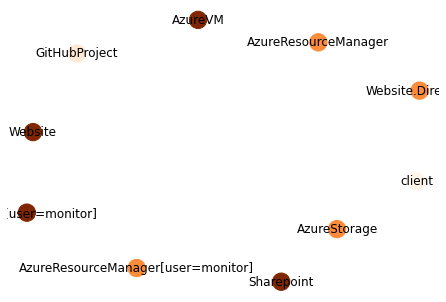

In [5]:
env.plot_environment_graph()

In [9]:
c2 = commandcontrol.CommandControl(env)
dbg = commandcontrol.EnvironmentDebugging(c2)
# def plot():
dbg.plot_discovered_network()
c2.print_all_attacks()
outcome = c2.run_attack('client', 'SearchEdgeHistory')
dbg.plot_discovered_network()
c2.print_all_attacks()
# plot()
github = c2.run_remote_attack('client', 'Website', 'ScanPageContent')
dbg.plot_discovered_network()


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]


INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,discovered,NaN,None,"[ScanPageContent, ScanPageSource]"


INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


In [10]:
leakedSasUrl = c2.run_remote_attack('client', 'GitHubProject',  'CredScanGitHistory')
dbg.plot_discovered_network()

INFO: discovered node: AzureStorage
INFO: discovered credential: CachedCredential(node='AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


In [11]:
blobwithflag = c2.connect_and_infect('client', 'AzureStorage', 'HTTPS', 'SASTOKEN1')
dbg.plot_discovered_network()
blobwithflag

INFO: Infected node 'AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


True

In [12]:
browsableDirectory = c2.run_remote_attack('client', 'Website', 'ScanPageSource')
dbg.plot_discovered_network()

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


In [13]:
outcome_mysqlleak = c2.run_remote_attack('client', 'Website.Directory', 'NavigateWebDirectoryFurther')
sharepoint_url = c2.run_remote_attack('client', 'Website.Directory', 'NavigateWebDirectory')
dbg.plot_discovered_network()

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


In [14]:
outcome_azure_ad = c2.run_remote_attack('client', 'Sharepoint', 'ScanSharepointParentDirectory')
dbg.plot_discovered_network()


INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


In [15]:
azureVmInfo = c2.connect_and_infect('client', 'AzureResourceManager', 'HTTPS', 'ADPrincipalCreds')
dbg.plot_discovered_network()

INFO: Infected node 'AzureResourceManager' from 'client' via HTTPS with credential 'ADPrincipalCreds'
INFO: Owned message: FLAG: Shared credentials with database user - Obtained secrets hidden in Azure Managed Resources


In [16]:
c2.run_remote_attack('client', 'AzureResourceManager', 'ListAzureResources')
dbg.plot_discovered_network()

INFO: discovered node: AzureVM
INFO: GOT REWARD: Obtained Azure VM and public IP information


In [17]:
should_fail = c2.connect_and_infect('client', 'AzureVM', 'SSH', 'ReusedMySqlCred-web')
print('Success=' + str(should_fail))
dbg.plot_discovered_network()

INFO: BLOCKED TRAFFIC: target node 'AzureVM' is blocking outgoing traffic on port 'SSH'
Success=False


In [18]:
owned = c2.connect_and_infect('client', 'Website', 'SSH', 'ReusedMySqlCred-web')
dbg.plot_discovered_network()

INFO: Infected node 'Website' from 'client' via SSH with credential 'ReusedMySqlCred-web'
INFO: Owned message: FLAG: Login using insecure SSH user/password


In [19]:
outcome = c2.run_attack('Website', 'CredScanBashHistory')
dbg.plot_discovered_network()

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


In [20]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,owned,"[MySql, Ubuntu, nginx/1.10.3]",[CredScanBashHistory],"[ScanPageContent, ScanPageSource]"
2,AzureStorage,owned,[CTFFLAG:LeakedCustomerData],[],[AccessDataWithSASToken]
3,AzureResourceManager,owned,[CTFFLAG:LeakedCustomerData2],[],[ListAzureResources]
4,GitHubProject,discovered,NaN,None,[CredScanGitHistory]
5,Website.Directory,discovered,NaN,None,"[NavigateWebDirectoryFurther, NavigateWebDirec..."
6,Sharepoint,discovered,NaN,None,[ScanSharepointParentDirectory]
7,AzureVM,discovered,NaN,None,[]
8,Website[user=monitor],discovered,NaN,None,[]


In [21]:
should_fail = c2.connect_and_infect('Website', 'Website[user=monitor]', 'sudo', 'monitorBashCreds')
dbg.plot_discovered_network()

INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking outgoing traffic on port 'sudo'


In [22]:
should_fail = c2.connect_and_infect('client', 'Website[user=monitor]', 'SSH', 'monitorBashCreds')
dbg.plot_discovered_network()
should_fail

INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking outgoing traffic on port 'SSH'


False

In [23]:
flag = c2.connect_and_infect('Website', 'Website[user=monitor]', 'su', 'monitorBashCreds')
dbg.plot_discovered_network()

INFO: Infected node 'Website[user=monitor]' from 'Website' via su with credential 'monitorBashCreds'
INFO: Owned message: FLAG User escalation by stealing credentials from bash history


In [24]:
outcome = c2.run_attack('Website[user=monitor]', 'CredScan-HomeDirectory')
dbg.plot_discovered_network()

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


In [25]:
secrets = c2.connect_and_infect('client', 'AzureResourceManager[user=monitor]', 'HTTPS', 'azuread_user_credentials')
dbg.plot_discovered_network()

INFO: Infected node 'AzureResourceManager[user=monitor]' from 'client' via HTTPS with credential 'azuread_user_credentials'
INFO: Owned message: More secrets stolen when logged as interactive `monitor` user in Azure with `az`


In [26]:
c2.print_all_attacks()

,id,status,properties,local_attacks,remote_attacks
0,client,owned,[],[SearchEdgeHistory],[]
1,Website,owned,"[MySql, Ubuntu, nginx/1.10.3]",[CredScanBashHistory],"[ScanPageContent, ScanPageSource]"
2,AzureStorage,owned,[CTFFLAG:LeakedCustomerData],[],[AccessDataWithSASToken]
3,AzureResourceManager,owned,[CTFFLAG:LeakedCustomerData2],[],[ListAzureResources]
4,Website[user=monitor],owned,"[MySql, Ubuntu, nginx/1.10.3]",[CredScan-HomeDirectory],[]
5,AzureResourceManager[user=monitor],owned,[],[],[]
6,GitHubProject,discovered,NaN,None,[CredScanGitHistory]
7,Website.Directory,discovered,NaN,None,"[NavigateWebDirectoryFurther, NavigateWebDirec..."
8,Sharepoint,discovered,NaN,None,[ScanSharepointParentDirectory]
9,AzureVM,discovered,NaN,None,[]
